In [1]:
import sys; sys.path.insert(0, '..')

In [2]:
import pandas as pd
from tqdm import notebook
from utils.regex_fx import remove_mention, remove_non_ascii, remove_emojis, remove_urls, remove_nonalpha, remove_extra_spaces, remove_special_words, remove_rt, remove_single_char, remove_numbers
import spacy
import re
nlp = spacy.load("en_core_web_sm")
from gensim.models import LdaMulticore, Phrases
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from collections import Counter

In [3]:
flatten = lambda t: [item for sublist in t for item in sublist]

In [4]:
all_collected = pd.read_pickle('../all_collected_users_en')

In [5]:
second_dataset_list = all_collected.claim_text.unique().tolist()

In [6]:
def cleanup(text):
    res = remove_mention(text)
    res = remove_non_ascii(res)
    res = res.lower()
    res = remove_urls(res)
    res = remove_rt(res)
    res = remove_single_char(res)
    res = remove_numbers(res)
    res = remove_emojis(res)
    res = remove_nonalpha(res)
    res = remove_extra_spaces(res)
    res = remove_special_words(res)
    return res

In [7]:
for item in range(0, len(second_dataset_list)):
    second_dataset_list[item] = cleanup(second_dataset_list[item])

In [8]:
combined = pd.read_csv('fake.csv').append(pd.read_csv('real.csv'))

In [9]:
text_list = combined.text.unique()
text_list = text_list.tolist()


In [10]:
text_list += second_dataset_list

In [11]:
len(text_list)

254563

In [12]:
processed_texts = [text for text in notebook.tqdm(nlp.pipe(text_list, 
                                                n_process=-1, # maximum number of threads
                                                disable=["ner", "parser"]),
                                                total=len(text_list))]

  0%|          | 0/254563 [00:00<?, ?it/s]

In [13]:
tokenized_texts = [[word.lemma_ for word in lemma_ if not word.is_punct if not word.is_stop] for lemma_ in notebook.tqdm(processed_texts)]

  0%|          | 0/254563 [00:00<?, ?it/s]

In [14]:
# rmv = ['nt', 's', 'say' ,'rt', 'm', 'barackobama', 'fox', 'trump', 'see', 'donald', 've', 'year', 'foxnew', 'de', 'cnn', 'amp', 'news', 'obama', 'realdonaldtrump', 'go', 'new']
rmv = ['nt', 's', ' ', 'm', 've', 'gt']
tokenized_texts = [[i for i in nested if i not in rmv ] for nested in tokenized_texts]

In [15]:
def make_n_grams(docs):
    # Add bigrams and trigrams to docs (only ones that appear 20 times or more).
    bigram = Phrases(docs, min_count=1)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if '_' in token:
                # Token is a bigram, add to document.
                docs[idx].append(token)
    return docs

In [16]:
def process_tokenized(tokenized_texts):
    # tokenized_texts = make_n_grams(tokenized_texts)
    flatten = lambda t: [item for sublist in t for item in sublist]
    flattened = flatten(tokenized_texts)
    counts = Counter(flattened)
    total_words = sum(counts.values()) 
    for word in counts:
        counts[word] = counts[word] #* (10000) / total_words
    return counts, counts.most_common(), flattened, tokenized_texts

In [17]:
tokenized_obj = process_tokenized(tokenized_texts)
counts_combined, common_combined, flattened_combined, tokenized_texts_combined = tokenized_obj

In [18]:
common_combined[:100]

[('trump', 26169),
 ('state', 21433),
 ('interview', 19275),
 ('house', 18979),
 ('president', 18745),
 ('news', 14836),
 ('say', 14756),
 ('amp', 13594),
 ('like', 13300),
 ('statement', 12652),
 ('speech', 12155),
 ('people', 12013),
 ('time', 11210),
 ('meetthepress', 11199),
 ('video', 11178),
 ('union', 11009),
 ('america', 10735),
 ('cnn', 10345),
 ('year', 9814),
 ('realdonaldtrump', 9806),
 ('know', 9388),
 ('representative', 9349),
 ('fox', 9286),
 ('white', 9196),
 ('watch', 9083),
 ('press', 8554),
 ('good', 8508),
 ('new', 8476),
 ('day', 8351),
 ('debate', 8336),
 ('percent', 8264),
 ('go', 8047),
 ('meet', 7959),
 ('nation', 7937),
 ('republican', 7935),
 ('think', 7793),
 ('face', 7674),
 ('need', 7568),
 ('obama', 7552),
 ('national', 7456),
 ('vote', 7450),
 ('want', 7259),
 ('get', 7185),
 ('american', 7166),
 ('report', 7166),
 ('briefing', 7100),
 ('today', 7096),
 ('facethenation', 7095),
 ('foxnew', 7025),
 ('week', 7015),
 ('youtube', 6990),
 ('right', 6857),
 ('

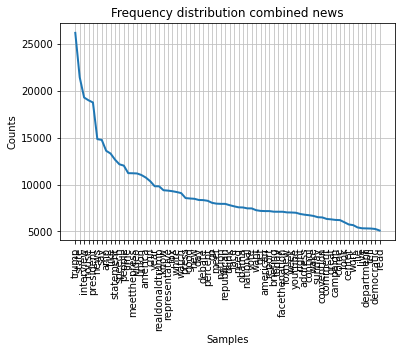

<AxesSubplot:title={'center':'Frequency distribution combined news'}, xlabel='Samples', ylabel='Counts'>

In [19]:
import nltk
from nltk import FreqDist
fdist_filtered = FreqDist(counts_combined)
fdist_filtered.plot(70,title='Frequency distribution combined news')

In [20]:
def compute_coherence_values(texts, start, step, limit, topn):
    dictionary = Dictionary(texts) # get the vocabulary
    dictionary.filter_extremes(no_below=5, no_above=0.5)
    corpus = [dictionary.doc2bow(text) for text in texts]
    
    coherence_values = []
    model_list = []
    for num_topics in notebook.tqdm(range(start, limit, step)):
        model = LdaMulticore( corpus=corpus, num_topics=num_topics, id2word=dictionary, alpha = 0.01, iterations = 400)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v', topn=topn)
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [21]:
# model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit= 40, topn=5)

In [22]:
all_scores = []
for n in range(5, 15, 5):
    model_list, coherence_values = compute_coherence_values(texts=tokenized_texts, start=1, step=1, limit=40, topn=n)
    all_scores.append(coherence_values)

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

In [23]:
import numpy as np

In [24]:
all_scores = np.array(all_scores)
avg_scores = np.average(all_scores, axis=0)
print(avg_scores)

[0.14604029 0.1651738  0.24305177 0.31019069 0.39172817 0.38519826
 0.43639986 0.43226546 0.48384488 0.46520617 0.45774952 0.46583898
 0.43306784 0.4484324  0.44542385 0.45271792 0.43492617 0.43601469
 0.46277017 0.44591566 0.45385947 0.49577613 0.45077378 0.46461442
 0.47449607 0.46960797 0.47870011 0.47047463 0.48113004 0.48100029
 0.4943087  0.48114677 0.47376117 0.45974837 0.47086166 0.48192864
 0.49746643 0.50189679 0.48014058]


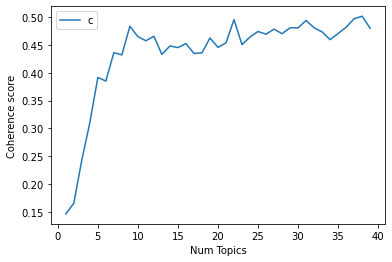

In [25]:
# Show graph
import matplotlib.pyplot as plt
limit=40; start=1; step=1;
x = range(start, limit, step)
plt.plot(x, avg_scores)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [26]:
def topic_modelling_results(tokenized_text, n_topics, n_iterations):
    results = []

    dictionary = Dictionary(tokenized_text) # get the vocabulary
    corpus = [dictionary.doc2bow(text) for text in tokenized_text]

    N_TOPICS = n_topics
    N_ITERATIONS = n_iterations

    lda = LdaMulticore(
                    corpus=corpus,
                    id2word=dictionary,
                    num_topics=N_TOPICS,
                    iterations=N_ITERATIONS)
    
    for topic in range(N_TOPICS):
        words = lda.show_topic(topic)
        topic_n_words = ' '.join([word[0] for word in words])
        result = {'Topic':str(topic), 
                    'Words':topic_n_words}
        results.append(result)
    results_DF = pd.DataFrame(results)
    pd.set_option('display.max_colwidth', None)
    return results_DF, lda, dictionary

In [27]:
topics, lda_combined, dictionary = topic_modelling_results(tokenized_texts, 35, n_iterations = 1000)
topics

,Topic,Words
0,0,state de house department video address representative union youtube national
1,1,house cnn comment representative america wake meetthepress facethenation people like
2,2,house trump representative america wake vote transcript debate republican video
3,3,federal house regulation code representative fake crime na trump america
4,4,house representative president america white senate vote state wake say
5,5,house control disease center prevention representative department america news state
6,6,league voter house conservation representative state time federal good trump
7,7,news fox america wake state sunday think need know trump
8,8,state house representative president union trump interview address vote report
9,9,house representative vote american meetthepress school america people music play
